# Installing all packages required (so far)

In [21]:
# RUN THIS ONCE
!pip install pynrrd
!pip install opencv-python
!pip install SimpleITK
!pip install ipywidgets
!pip install scipy

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
from pathlib import Path
from ipywidgets import interact, fixed
from IPython.display import clear_output
import gc

# Helper functions for loading cases in

In [2]:
# Helper functions to load single cases one at a time

def get_file_paths(case_id, data_root="../HaN-Seg/set_1"):
    case_num = f"{case_id:02d}"
    case_dir = Path(data_root) / f"case_{case_num}"
    
    return {
        'ct': case_dir / f"case_{case_num}_IMG_CT.nrrd", #1024x1024 images with varying depth
        'mri': case_dir / f"case_{case_num}_IMG_MR_T1.nrrd", #512x512 images with varying depth
        'seg': case_dir / f"case_{case_num}_OAR_Bone_Mandible.seg.nrrd" #1024x1024 images with varying depth
    }

def load_single_case(case_id):
    """Load a single case (CT, MRI, segmentation) - memory efficient!"""
    paths = get_file_paths(case_id)
    
    return {
        'ct': sitk.ReadImage(str(paths['ct']), sitk.sitkFloat32),
        'mri': sitk.ReadImage(str(paths['mri']), sitk.sitkFloat32),
        'seg': sitk.ReadImage(str(paths['seg']), sitk.sitkFloat32)
    }

# Visualization functions (used in registration)

Source: 

In [ ]:
# Visualization helper functions
# Callback invoked by the IPython interact method for scrolling through image stacks of
# the two images being registered.
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size
    plt.subplots(1, 2, figsize=(10, 8))
    
    # Draw the fixed image in the first subplot
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")
    
    # Draw the moving image in the second subplot
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space
def display_images_with_alpha(image_z, alpha, fixed, moving):
    """Display two images with alpha blending."""
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.title(f"Slice {image_z}")
    plt.show()

# Helper functions for preprocessing

In [4]:
# Function to remove the CT bed in CT scans
def remove_ct_bed(ct_image, threshold=-300, erosion_radius=5):
    
    print("Removing CT bed...")
    
    # Convert to array
    ct_array = sitk.GetArrayFromImage(ct_image)
    
    # Threshold to get body (above threshold)
    body_binary = ct_array > threshold
    
    # Find largest connected component (assumes body is largest)
    from scipy import ndimage
    labeled, num_features = ndimage.label(body_binary)
    
    if num_features > 0:
        # Get sizes of all components
        sizes = ndimage.sum(body_binary, labeled, range(1, num_features + 1))
        # Keep only the largest component (the body)
        largest_component = np.argmax(sizes) + 1
        body_mask = (labeled == largest_component)
        
        # Morphological closing to fill holes
        struct = ndimage.generate_binary_structure(3, 2)
        body_mask = ndimage.binary_closing(body_mask, structure=struct, iterations=3)
        
        # Apply mask to CT
        ct_cleaned_array = ct_array.copy()
        ct_cleaned_array[~body_mask] = ct_array.min()  # Set background to minimum HU
    else:
        body_mask = body_binary
        ct_cleaned_array = ct_array
    
    # Convert back to SimpleITK image
    ct_cleaned = sitk.GetImageFromArray(ct_cleaned_array)
    ct_cleaned.CopyInformation(ct_image)
    
    body_mask_img = sitk.GetImageFromArray(body_mask.astype(np.uint8))
    body_mask_img.CopyInformation(ct_image)
    
    print(f"  Body volume: {body_mask.sum() / body_mask.size * 100:.1f}% of image")
    
    return ct_cleaned, body_mask_img

## Testing preprocessing

Testing preprocessing on case 1...

Original CT size: (1024, 1024, 202)
Original MRI size: (512, 512, 83)

TEST 1: CT Bed Removal
Removing CT bed...
  Body volume: 9.2% of image


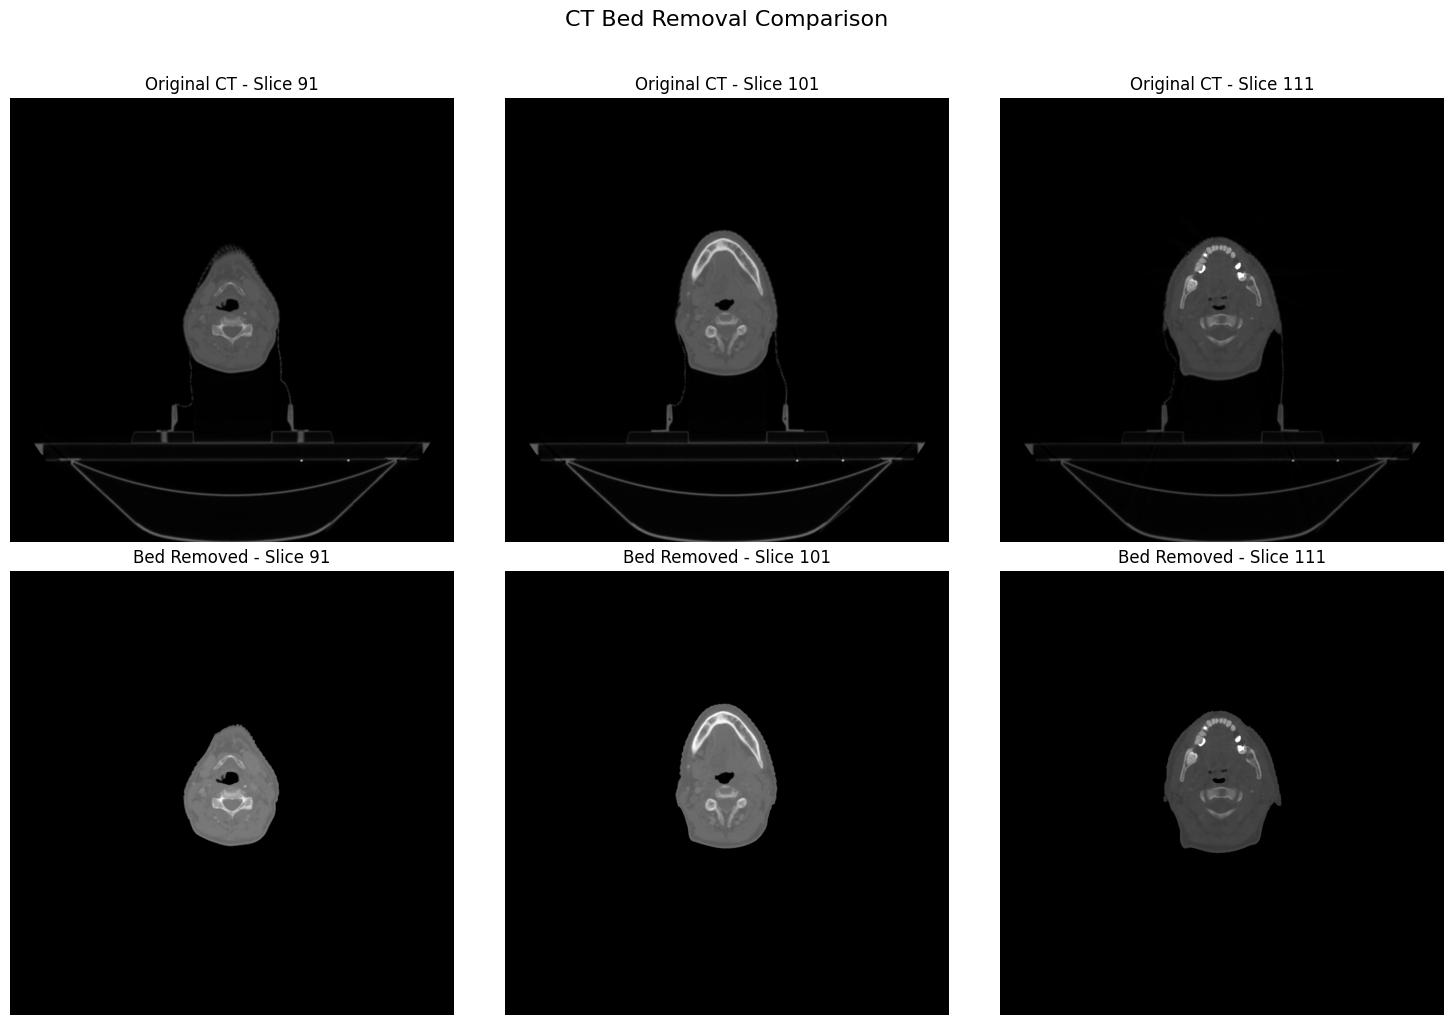

In [6]:
# TESTING IF CT REMOVAL WORKED
test_case_id = 1
print(f"Testing preprocessing on case {test_case_id}...\n")

data = load_single_case(test_case_id)
ct_original = data['ct']
mri_original = data['mri']

print(f"Original CT size: {ct_original.GetSize()}")
print(f"Original MRI size: {mri_original.GetSize()}")

# Test 1: Bed removal
print("\n" + "="*60)
print("TEST 1: CT Bed Removal")
print("="*60)

ct_cleaned, body_mask = remove_ct_bed(ct_original, threshold=-300)

# Visualize bed removal results
ct_orig_array = sitk.GetArrayFromImage(ct_original)
ct_clean_array = sitk.GetArrayFromImage(ct_cleaned)
body_mask_array = sitk.GetArrayFromImage(body_mask)

mid_slice = ct_orig_array.shape[0] // 2

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Different slices of original
axes[0, 0].imshow(ct_orig_array[mid_slice - 10], cmap='gray')
axes[0, 0].set_title(f'Original CT - Slice {mid_slice - 10}')
axes[0, 0].axis('off')

axes[0, 1].imshow(ct_orig_array[mid_slice], cmap='gray')
axes[0, 1].set_title(f'Original CT - Slice {mid_slice}')
axes[0, 1].axis('off')

axes[0, 2].imshow(ct_orig_array[mid_slice + 10], cmap='gray')
axes[0, 2].set_title(f'Original CT - Slice {mid_slice + 10}')
axes[0, 2].axis('off')

# Row 2: After bed removal
axes[1, 0].imshow(ct_clean_array[mid_slice - 10], cmap='gray')
axes[1, 0].set_title(f'Bed Removed - Slice {mid_slice - 10}')
axes[1, 0].axis('off')

axes[1, 1].imshow(ct_clean_array[mid_slice], cmap='gray')
axes[1, 1].set_title(f'Bed Removed - Slice {mid_slice}')
axes[1, 1].axis('off')

axes[1, 2].imshow(ct_clean_array[mid_slice + 10], cmap='gray')
axes[1, 2].set_title(f'Bed Removed - Slice {mid_slice + 10}')
axes[1, 2].axis('off')

plt.suptitle('CT Bed Removal Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Registration
ALL CODE BELOW IS FROM THE SIMPLEITK TUTORIAL
https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html

## Helper functions

In [7]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    metric_values.append(registration_method.GetMetricValue())

    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)

    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Registration function

In [8]:
# Registration function
def register_mri_to_ct(ct_image, mri_image, metrics=True):
    
    # Initialize transform
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        mri_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )
    
    # Setup registration method
    registration_method = sitk.ImageRegistrationMethod()
    
    # Similarity metric settings
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    
    # Optimizer settings
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    # Setup for the multi-resolution framework
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    
    # Execute registration
    final_transform = registration_method.Execute(
        sitk.Cast(ct_image, sitk.sitkFloat32),
        sitk.Cast(mri_image, sitk.sitkFloat32)
    )
    
    if metrics:
        print(f"Final metric value: {registration_method.GetMetricValue()}")
        print(f"Optimizer stop condition: {registration_method.GetOptimizerStopConditionDescription()}")
    
    # Resample CT to MRI space
    min_value = float(sitk.GetArrayViewFromImage(mri_image).min())
    registered_mri = sitk.Resample(
        mri_image,
        ct_image,
        final_transform,
        sitk.sitkLinear,
        min_value,
        mri_image.GetPixelID(),
    )
    
    return registered_mri, final_transform

## Registration quality function - kinda sketch

In [9]:
# Registration quality heatmap - edge-based
def compute_edge_alignment_map(ct_array, mri_array, sigma=1.0):
    
    from scipy.ndimage import gaussian_gradient_magnitude, uniform_filter
    
    print("Computing edge-based registration quality...")
    
    # Get middle slice
    mid_slice = ct_array.shape[0] // 2
    ct_slice = ct_array[mid_slice].astype(np.float32)
    mri_slice = mri_array[mid_slice].astype(np.float32)
    
    # Compute edge maps using gradient magnitude
    ct_edges = gaussian_gradient_magnitude(ct_slice, sigma=sigma)
    mri_edges = gaussian_gradient_magnitude(mri_slice, sigma=sigma)
    
    # Normalize edge maps
    ct_edges_norm = (ct_edges - ct_edges.min()) / (ct_edges.max() - ct_edges.min() + 1e-8)
    mri_edges_norm = (mri_edges - mri_edges.min()) / (mri_edges.max() - mri_edges.min() + 1e-8)
    
    # Compute local edge correlation
    window_size = 5
    
    ct_mean = uniform_filter(ct_edges_norm, window_size)
    mri_mean = uniform_filter(mri_edges_norm, window_size)
    
    ct_var = uniform_filter(ct_edges_norm**2, window_size) - ct_mean**2
    mri_var = uniform_filter(mri_edges_norm**2, window_size) - mri_mean**2
    
    cross_corr = uniform_filter(ct_edges_norm * mri_edges_norm, window_size) - ct_mean * mri_mean
    
    # Local edge correlation coefficient
    edge_alignment_map = cross_corr / (np.sqrt(ct_var * mri_var) + 1e-8)
    
    return edge_alignment_map, ct_edges, mri_edges


## Normalization

In [10]:
# Normalization function
def normalize_image(image):
    
    if isinstance(image, np.ndarray):
        img_array = image.astype(np.float32)
    else:
        img_array = sitk.GetArrayViewFromImage(image).astype(np.float32)
    
    mean = np.mean(img_array)
    std = np.sqrt(np.mean(img_array ** 2) - mean ** 2)
    
    normalized = (img_array - mean) / (std + 1e-8)
    
    return normalized, {'mean': mean, 'std': std}

# Loading in a case

In [11]:
# Load and process a single case (for memory efficiency - Rohan)
case_id = 4  # Change this to process different patient cases

print(f"Loading case {case_id}...")
data = load_single_case(case_id)
ct = data['ct']
mri = data['mri']
seg = data['seg']

print(f"CT shape: {ct.GetSize()}")
print(f"MRI shape: {mri.GetSize()}")
print(f"Segmentation shape: {seg.GetSize()}")

Loading case 4...
CT shape: (1024, 1024, 184)
MRI shape: (512, 512, 57)
Segmentation shape: (1024, 1024, 184)


# Running registration

In [12]:
# Running the function that registers the patient CT to patient MRI
print(f"Registering MRI to CT space...")
registered_mri, final_transform = register_mri_to_ct(ct, mri, metrics=True)

Registering MRI to CT space...
Final metric value: -0.46853023072870925
Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [13]:
# Registration visualization overlay (sliders for slices and alpha)
interact(
    display_images_with_alpha,
    image_z=(0, ct.GetSize()[2] - 1),
    alpha=(0.0, 1.0, 0.05),
    fixed=fixed(ct),
    moving=fixed(registered_mri),
);

interactive(children=(IntSlider(value=91, description='image_z', max=183), FloatSlider(value=0.5, description=…

Computing edge-based registration quality...


C:\Users\mlykw\AppData\Local\Temp\ipykernel_18372\3800566633.py:33: RuntimeWarning: invalid value encountered in sqrt
  edge_alignment_map = cross_corr / (np.sqrt(ct_var * mri_var) + 1e-8)


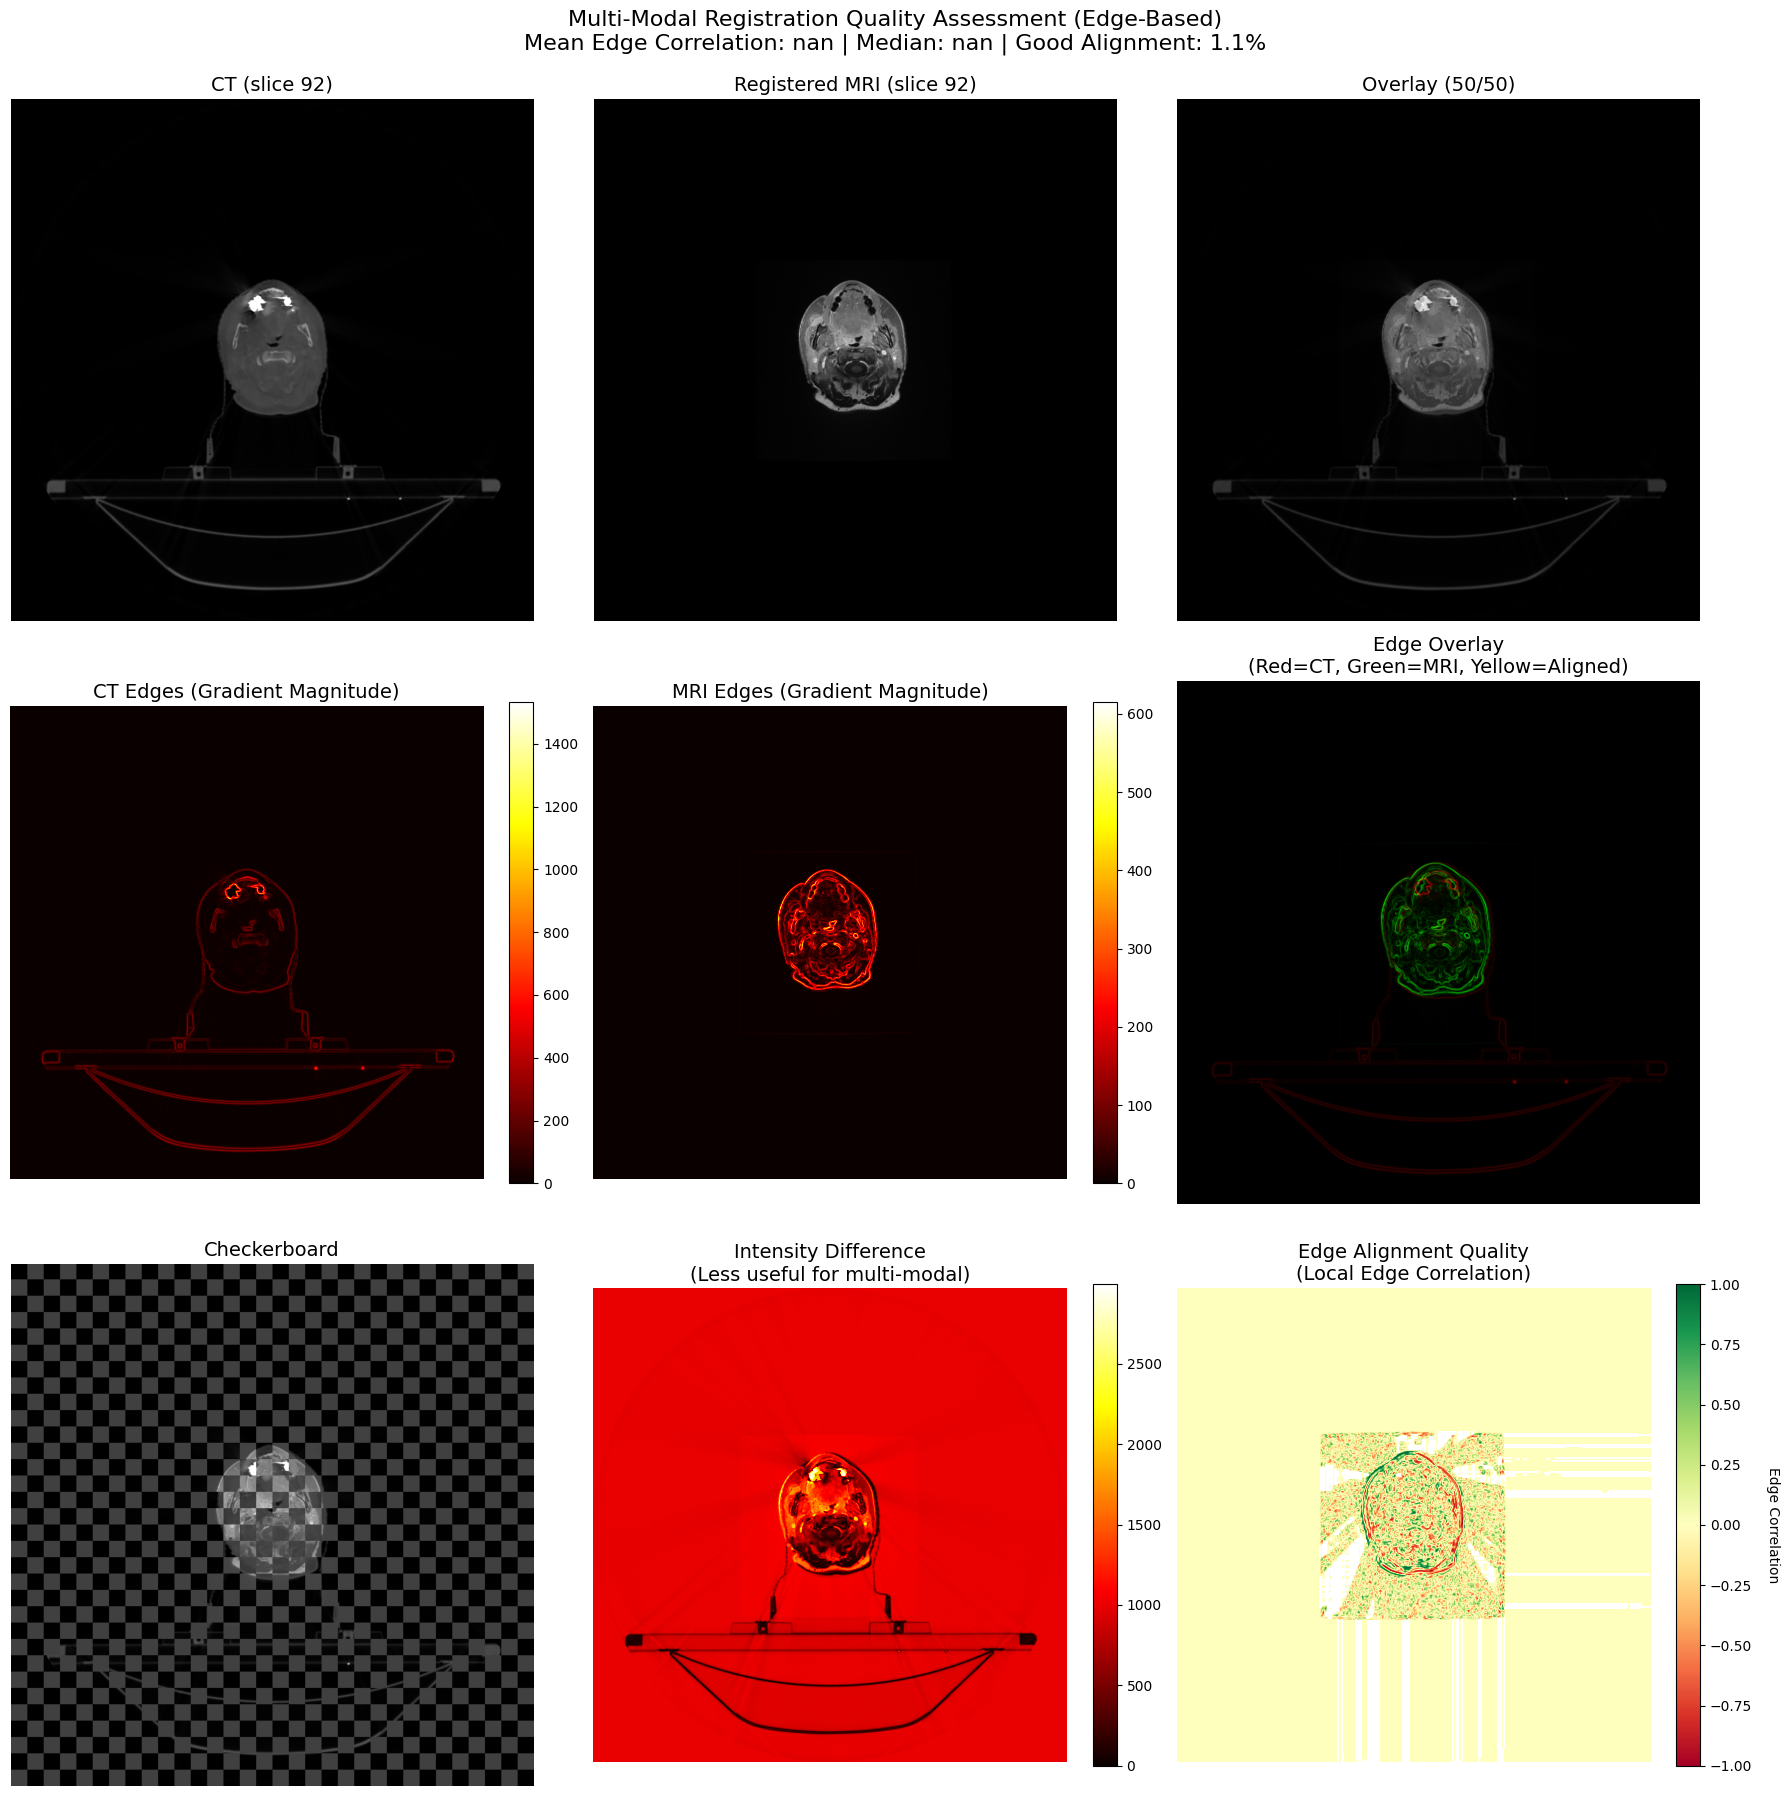


=== Edge-Based Registration Quality Metrics ===
Mean edge correlation: nan
Median edge correlation: nan
% of well-aligned edges (corr > 0.5): 1.1%

Edge strength - CT: 8.63, MRI: 4.24


In [14]:
# JUST FOR TRYING OUT REGISTRATION QUALITY
ct_array = sitk.GetArrayFromImage(ct).copy()
mri_registered_array = sitk.GetArrayFromImage(registered_mri).copy()

# Compute edge-based quality metrics
edge_quality_map, ct_edges, mri_edges = compute_edge_alignment_map(ct_array, mri_registered_array)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

mid_slice = ct_array.shape[0] // 2

# Row 1: Original images
axes[0, 0].imshow(ct_array[mid_slice], cmap='gray')
axes[0, 0].set_title(f'CT (slice {mid_slice})', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(mri_registered_array[mid_slice], cmap='gray')
axes[0, 1].set_title(f'Registered MRI (slice {mid_slice})', fontsize=14)
axes[0, 1].axis('off')

# Overlay
overlay = 0.5 * ct_array[mid_slice] + 0.5 * mri_registered_array[mid_slice]
axes[0, 2].imshow(overlay, cmap='gray')
axes[0, 2].set_title('Overlay (50/50)', fontsize=14)
axes[0, 2].axis('off')

# Row 2: Edge detection
im1 = axes[1, 0].imshow(ct_edges, cmap='hot')
axes[1, 0].set_title('CT Edges (Gradient Magnitude)', fontsize=14)
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], fraction=0.046)

im2 = axes[1, 1].imshow(mri_edges, cmap='hot')
axes[1, 1].set_title('MRI Edges (Gradient Magnitude)', fontsize=14)
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)

# Edge overlay (edges should align if registration is good)
edge_overlay = np.zeros((*ct_edges.shape, 3))
edge_overlay[..., 0] = ct_edges / (ct_edges.max() + 1e-8)  # CT edges in red
edge_overlay[..., 1] = mri_edges / (mri_edges.max() + 1e-8)  # MRI edges in green
# Where edges overlap (yellow) = good alignment
axes[1, 2].imshow(edge_overlay)
axes[1, 2].set_title('Edge Overlay\n(Red=CT, Green=MRI, Yellow=Aligned)', fontsize=14)
axes[1, 2].axis('off')

# Row 3: Quality metrics
# Checkerboard pattern
checker_size = 32
checker = np.zeros_like(ct_array[mid_slice])
for i in range(0, ct_array.shape[1], checker_size):
    for j in range(0, ct_array.shape[2], checker_size):
        if ((i // checker_size) + (j // checker_size)) % 2 == 0:
            checker[i:i+checker_size, j:j+checker_size] = ct_array[mid_slice, i:i+checker_size, j:j+checker_size]
        else:
            checker[i:i+checker_size, j:j+checker_size] = mri_registered_array[mid_slice, i:i+checker_size, j:j+checker_size]
axes[2, 0].imshow(checker, cmap='gray')
axes[2, 0].set_title('Checkerboard', fontsize=14)
axes[2, 0].axis('off')

# Difference map
diff_map = np.abs(ct_array[mid_slice] - mri_registered_array[mid_slice])
im3 = axes[2, 1].imshow(diff_map, cmap='hot')
axes[2, 1].set_title('Intensity Difference\n(Less useful for multi-modal)', fontsize=14)
axes[2, 1].axis('off')
plt.colorbar(im3, ax=axes[2, 1], fraction=0.046)

# Edge alignment heatmap
im4 = axes[2, 2].imshow(edge_quality_map, cmap='RdYlGn', vmin=-1, vmax=1)
axes[2, 2].set_title('Edge Alignment Quality\n(Local Edge Correlation)', fontsize=14)
axes[2, 2].axis('off')
cbar = plt.colorbar(im4, ax=axes[2, 2], fraction=0.046)
cbar.set_label('Edge Correlation', rotation=270, labelpad=20)

# Overall statistics
mean_edge_corr = np.mean(edge_quality_map)
median_edge_corr = np.median(edge_quality_map)
good_alignment_pct = (edge_quality_map > 0.5).sum() / edge_quality_map.size * 100

plt.suptitle(f'Multi-Modal Registration Quality Assessment (Edge-Based)\n'
             f'Mean Edge Correlation: {mean_edge_corr:.3f} | '
             f'Median: {median_edge_corr:.3f} | Good Alignment: {good_alignment_pct:.1f}%', 
             fontsize=16, y=0.995)

plt.tight_layout()
plt.show()

print(f"\n=== Edge-Based Registration Quality Metrics ===")
print(f"Mean edge correlation: {mean_edge_corr:.3f}")
print(f"Median edge correlation: {median_edge_corr:.3f}")
print(f"% of well-aligned edges (corr > 0.5): {good_alignment_pct:.1f}%")

# Additional edge metrics
ct_edge_strength = np.mean(ct_edges)
mri_edge_strength = np.mean(mri_edges)
print(f"\nEdge strength - CT: {ct_edge_strength:.2f}, MRI: {mri_edge_strength:.2f}")



# Performing normalization

In [15]:
# Normalize images 
print("Normalizing images...")

# Convert to numpy arrays
ct_array = sitk.GetArrayViewFromImage(ct).astype(np.float32)
mri_registered_array = sitk.GetArrayViewFromImage(registered_mri).astype(np.float32)
seg_array = sitk.GetArrayFromImage(seg).astype(np.float32)

# Normalize CT
ct_normalized, ct_stats = normalize_image(ct_array)

# Normalize registered MRI
mri_normalized, mri_stats = normalize_image(mri_registered_array)

print(f"\nOriginal Statistics:")
print(f"CT - Mean: {ct_stats['mean']:.2f}, Std: {ct_stats['std']:.2f}")
print(f"MRI - Mean: {mri_stats['mean']:.2f}, Std: {mri_stats['std']:.2f}")

print(f"\nNormalized Statistics:")
print(f"CT - Mean: {np.mean(ct_normalized):.6f}, Std: {np.std(ct_normalized):.6f}")
print(f"MRI - Mean: {np.mean(mri_normalized):.6f}, Std: {np.std(mri_normalized):.6f}")

print(f"\nArray shapes:")
print(f"CT normalized: {ct_normalized.shape}")
print(f"MRI normalized: {mri_normalized.shape}")
print(f"Segmentation: {seg_array.shape}")

Normalizing images...

Original Statistics:
CT - Mean: -910.93, Std: 276.37
MRI - Mean: 17.91, Std: 117.17

Normalized Statistics:
CT - Mean: -0.000049, Std: 0.999858
MRI - Mean: 0.000001, Std: 1.000015

Array shapes:
CT normalized: (184, 1024, 1024)
MRI normalized: (184, 1024, 1024)
Segmentation: (184, 1024, 1024)


# Save processed data (if needed)

In [17]:
# Save processed data back to computer (TO USE IF THERE'S LOTS OR PREPROCESSING WE DON'T WANT TO KEEP RUNNING)
# NOT GOOD RIGHT NOW
output_dir = Path("./processed_data")
output_dir.mkdir(parents=True, exist_ok=True)

case_num = f"{case_id:02d}"
np.save(output_dir / f"case_{case_num}_mri_normalized.npy", mri_normalized)
np.save(output_dir / f"case_{case_num}_ct_registered_normalized.npy", ct_normalized)
np.save(output_dir / f"case_{case_num}_segmentation.npy", seg_array)
sitk.WriteTransform(final_transform, str(output_dir / f"case_{case_num}_transform.tfm"))

print(f"Saved processed data to {output_dir}")

# Free memory
del ct, mri, seg, ct_array, mri_array, ct_registered_array
gc.collect()

Saved processed data to processed_data


NameError: name 'ct' is not defined

# TO USE LATER - Process all cases through entire pipeline

In [18]:
# Process all cases (only to run once above code looks good)
# NOT GOOD RIGHT NOW
def process_all_cases(start_case=1, end_case=42, output_dir="./processed_data"):
    """Process all cases sequentially to avoid memory issues."""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    for case_id in range(start_case, end_case + 1):
        try:
            print(f"\n{'='*60}")
            print(f"Processing case {case_id}/{end_case}")
            print(f"{'='*60}")
            
            # Load case
            data = load_single_case(case_id)
            ct = data['ct']
            mri = data['mri']
            seg = data['seg']
            
            # Register
            registered_ct, transform = register_ct_to_mri(ct, mri, metrics=True)
            
            # Normalize
            mri_norm, _ = normalize_image(mri)
            ct_norm, _ = normalize_image(registered_ct)
            seg_array = sitk.GetArrayFromImage(seg).astype(np.float32)
            
            # Save
            case_num = f"{case_id:02d}"
            np.save(output_path / f"case_{case_num}_mri_normalized.npy", mri_norm)
            np.save(output_path / f"case_{case_num}_ct_registered_normalized.npy", ct_norm)
            np.save(output_path / f"case_{case_num}_segmentation.npy", seg_array)
            sitk.WriteTransform(transform, str(output_path / f"case_{case_num}_transform.tfm"))
            
            print(f"✓ Case {case_id} complete - saved to {output_path}")
            
            # Free memory
            del ct, mri, seg, registered_ct, transform
            del mri_norm, ct_norm, seg_array, data
            gc.collect()
            
        except Exception as e:
            print(f"✗ Error processing case {case_id}: {e}")
            continue
    
    print(f"\n{'='*60}")
    print("Processing complete!")
    print(f"{'='*60}")

# Final pre-CNN preprocessing

In [19]:
# Additional preprocessing for CNN
def preprocess_for_cnn(ct_norm, mri_norm, seg, clip_percentile=99.5):
    
    print("Additional preprocessing for CNN...")
    
    # Clip extreme outliers
    ct_max = np.percentile(ct_norm, clip_percentile)
    ct_min = np.percentile(ct_norm, 100 - clip_percentile)
    ct_clipped = np.clip(ct_norm, ct_min, ct_max)
    
    mri_max = np.percentile(mri_norm, clip_percentile)
    mri_min = np.percentile(mri_norm, 100 - clip_percentile)
    mri_clipped = np.clip(mri_norm, mri_min, mri_max)
    
    # 2. Re-normalize after clipping
    ct_final = (ct_clipped - ct_clipped.mean()) / (ct_clipped.std() + 1e-8)
    mri_final = (mri_clipped - mri_clipped.mean()) / (mri_clipped.std() + 1e-8)
    
    # 3. Convert segmentation to binary mask (if not already)
    seg_binary = (seg > 0).astype(np.float32)
    
    # 4. Stack CT and MRI as multi-channel input (common for multi-modal CNNs)
    # Shape: (depth, height, width, 2) - 2 channels
    multi_modal = np.stack([ct_final, mri_final], axis=-1)
    
    print(f"  CT clipped range: [{ct_clipped.min():.2f}, {ct_clipped.max():.2f}]")
    print(f"  MRI clipped range: [{mri_clipped.min():.2f}, {mri_clipped.max():.2f}]")
    print(f"  Segmentation: {seg_binary.sum():.0f} positive voxels ({seg_binary.mean()*100:.2f}%)")
    print(f"  Multi-modal shape: {multi_modal.shape}")
    
    return {
        'ct': ct_final,
        'mri': mri_final,
        'multi_modal': multi_modal,
        'segmentation': seg_binary,
        'ct_stats': {'min': ct_min, 'max': ct_max},
        'mri_stats': {'min': mri_min, 'max': mri_max}
    }

In [20]:
# Apply preprocessing
preprocessed = preprocess_for_cnn(ct_normalized, mri_normalized, seg_array)

Additional preprocessing for CNN...
  CT clipped range: [-0.32, 4.55]
  MRI clipped range: [-0.15, 8.33]
  Segmentation: 56337 positive voxels (0.03%)
  Multi-modal shape: (184, 1024, 1024, 2)


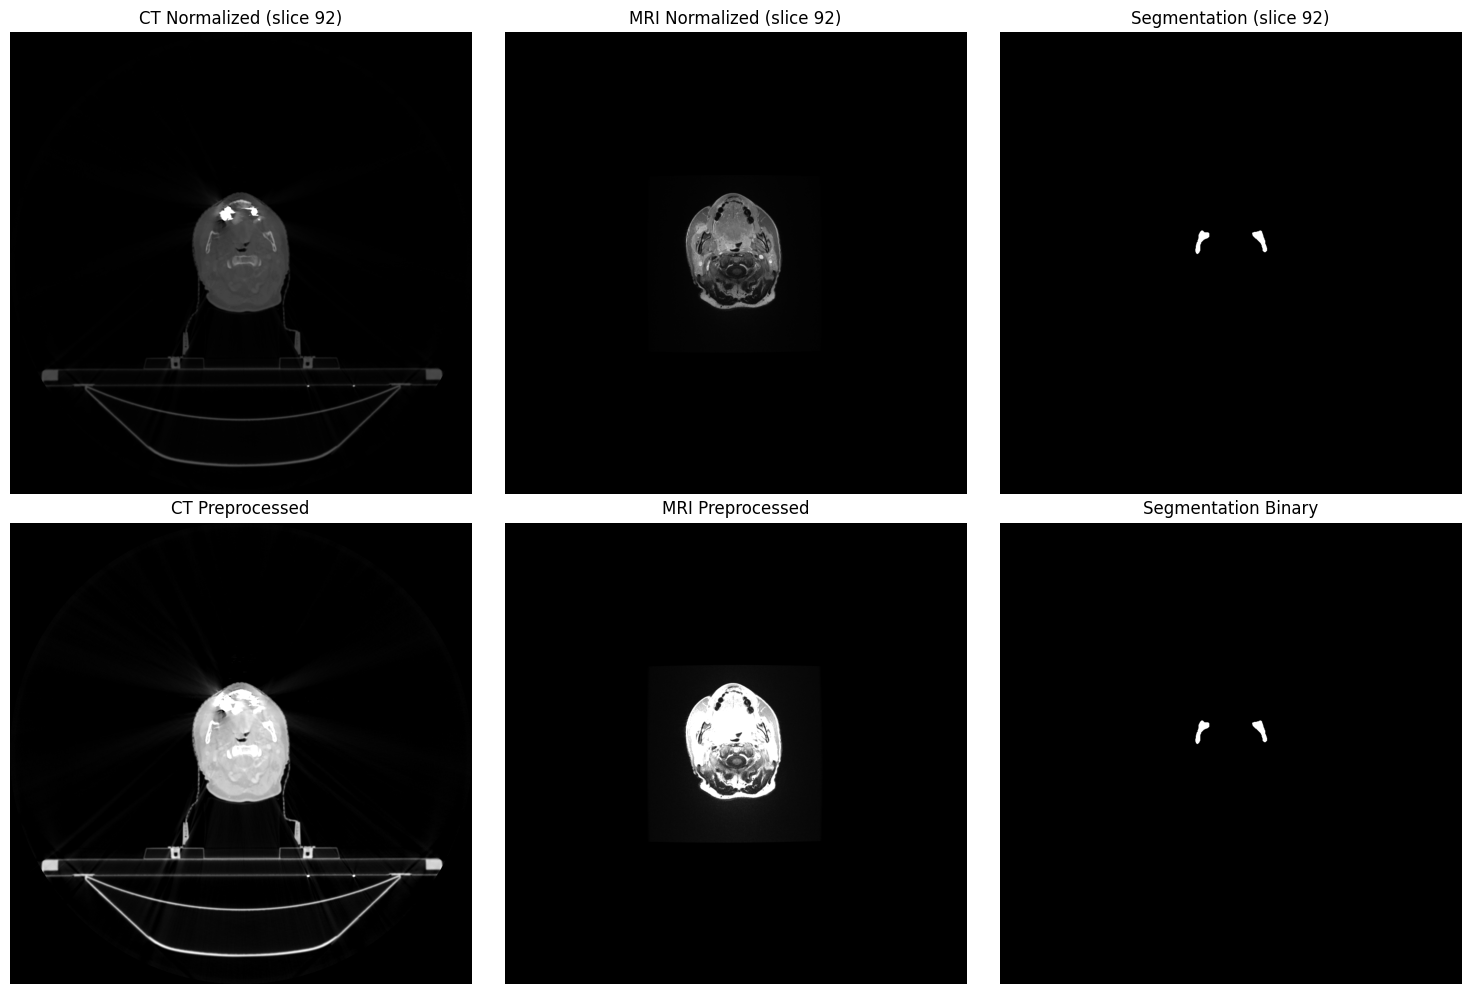

In [21]:
# Visualize preprocessed data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

mid_slice = ct_normalized.shape[0] // 2

# Original normalized
axes[0, 0].imshow(ct_normalized[mid_slice], cmap='gray')
axes[0, 0].set_title(f'CT Normalized (slice {mid_slice})')
axes[0, 0].axis('off')

axes[0, 1].imshow(mri_normalized[mid_slice], cmap='gray')
axes[0, 1].set_title(f'MRI Normalized (slice {mid_slice})')
axes[0, 1].axis('off')

axes[0, 2].imshow(seg_array[mid_slice], cmap='gray')
axes[0, 2].set_title(f'Segmentation (slice {mid_slice})')
axes[0, 2].axis('off')

# Preprocessed
axes[1, 0].imshow(preprocessed['ct'][mid_slice], cmap='gray')
axes[1, 0].set_title('CT Preprocessed')
axes[1, 0].axis('off')

axes[1, 1].imshow(preprocessed['mri'][mid_slice], cmap='gray')
axes[1, 1].set_title('MRI Preprocessed')
axes[1, 1].axis('off')

axes[1, 2].imshow(preprocessed['segmentation'][mid_slice], cmap='gray')
axes[1, 2].set_title('Segmentation Binary')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Preparing Data for Training/Testing

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

BATCH_SIZE = 64
BUFFER_SIZE = 1000
RANDOM_SEED = 42

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(slices, slices_gt, test_size=0.2, random_state=RANDOM_SEED)

print(type(X_train))

NameError: name 'slices' is not defined

In [ ]:
mri_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, zoom_range=0.2)
mask_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

image_generator = mri_datagen.flow(
    X_train,
    batch_size=BATCH_SIZE,
    seed = RANDOM_SEED
)

mask_generator = mask_datagen.flow(
    y_train,
    batch_size=BATCH_SIZE,
    seed = RANDOM_SEED
)

train_generator = zip(image_generator, mask_generator)

test_image_generator = test_datagen.flow(
    X_test,
    batch_size=BATCH_SIZE,
    shuffle = False,
    seed = RANDOM_SEED
)

test_mask_generator = mask.datagen.flow(
    y_test,
    batch_size=BATCH_SIZE,
    shuffle = False,
    seed = RANDOM_SEED
)

test_generator = zip(test_image_generator, test_mask_generator)

# U-Net CNN Model
Sources:

https://www.geeksforgeeks.org/machine-learning/u-net-architecture-explained/

https://medium.com/@alejandro.itoaramendia/decoding-the-u-net-a-complete-guide-810b1c6d56d8

In [ ]:
## A single Encoding step in the Contracting path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (n/2 x n/2) with num_channels feature channels
def encode_block(inputs, num_channels):
    # Extract num_channels feature channels from image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='valid')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Downsample each channels feature map by a factor of 2
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

    return x

## A single Decoding step in the Expanding path of a U-Net CNN
## @Inputs:
##       inputs: image of size (nxn) with k feature channels
##       skip_connection: tensor of corresponding encoding block
##       num_channels: number of channels to have in output image (i.e. depth of output tensor)
## @Outputs: 
##       x: image of size (2nx2n) with num_channels feature channels
def decode_block(inputs, skip_connection, num_channels):
    # Upsample image by doubling feature space while changing feature channels to num_channels
    x = tf.keras.layers.Conv2DTranspose(num_channels, (2,2), strides=2, padding='valid')(inputs)

    # Concatonate the skip_channel and the upsampled image (doubles the feature channels)
    # Might need to resize skip_connection, but should be fine b/c same padding in encoding
    x = tf.keras.layers.Concatonate()([x, skip_connection])
    
    # Merge feature channels from the skip_connection and upsampled input image
    x = tf.keras.layers.Conv2D(num_channels, 3, padding='valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_channels, 3, padding='valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [ ]:
# Metrics
# Source: https://medium.com/mastering-data-science/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
def dice_coeff(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    return (2*tp)/(2*tp + fp + fn)

def rand_index(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    return tp / (tp + fp + fn)

def jaccard_index(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    return (tp + tn) / (tp + tn + fn + fp)

def specificity(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_negatives = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(1 - y_true, tf.float32))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

In [ ]:
## Defining the model

input = tf.keras.layers.Input(shape=(1024, 1024, 1))

# Do 5 calls of encode_block to end up with a 32x32x512 tensor
e1 = encode_block(mri_image_reg, 32)
e2 = encode_block(e1, 64)
e3 = encode_block(e1, 128)
e4 = encode_block(e1, 256)
e5 = encode_block(e1, 512)

# Bottleneck
b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(e5)
b1 = tf.keras.layers.Activation('relu')(b1)
b1 = tf.keras.layers.Conv2D(1024, 3, padding='valid')(b1)
b1 = tf.keras.layers.Activation('relu')(b1)

# Do 5 calls of decode_block
d1 = decode_block(b1, e5, 512)
d2 = decode_block(d1, e4, 256)
d3 = decode_block(d2, e3, 128)
d4 = decode_block(d3, e2, 64)
d5 = decode_block(d4, e1, 32)

# Play around with activation
output = tf.keras.layers.Conv2D(1, 1, padding='valid', activation='softmax')(d4)

model = tf.keras.models.Model(inputs=input, outputs=output, name='U-Net')

model.compile(
    optimizer = 'adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy', dice_coeff, specificity, rand_index, jaccard_index]
)

#TODO Finish this

NameError: name 'tf' is not defined